In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import os, time, dask
import matplotlib.pyplot as plt
import dyl_function_slope as dyl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.colors import BoundaryNorm
from cartopy.util import add_cyclic_point
import matplotlib.patches as patches
from plot_CAT_function import calculate_consistency_2d,plot_trend,plot_routes_on_map,plot_bbox
import areamean_dhq as dhq
from scipy import stats
import cmaps
ccmap = cmaps.NEO_div_vegetation_a
plt.rcParams['font.family'] = 'Arial'

In [2]:
IN_DIR = "/home/dongyl/Work2_2025/ERA5_daily"
OUT_DIR = "/home/dongyl/Work2_2025/ERA5_daily"
os.makedirs(OUT_DIR, exist_ok=True)

YEARS = list(range(1979, 2024+1))#2015
LAT_MIN, LAT_MAX = 20, 60
Q=0.95

In [3]:
freq_ay = []
u_ay = []
for year in YEARS:
    freq = xr.open_dataset((f"{IN_DIR}/era5_TI1_exceed_pct_{year}_{int(Q * 100)}p.nc"))
    freq_subset = freq.sel(lat=slice(10, 80))
    freq = freq_subset["frequency"]
    freq_ay.append(freq)
    print(f"{year} freq loaded ")

    u = xr.open_dataset(f"{IN_DIR}/everyyear_levels_50-300_merged/era5-u-{year}-50-300hpa.nc").u[:,:,::-1]
    u_subset = u.sel(lat=slice(10, 80))
    #u = u_subset["u"]
    u_mean= np.nanmean(u_subset,axis=0)
    u_ay.append(u_mean)
    print(f"{year} u loaded ")

freq_ay_stack = np.stack(freq_ay, axis=0)
u_ay_stack = np.stack(u_ay, axis=0)
# 创建 DataArray，直接指定 year 坐标
combined_freq = xr.DataArray(
    freq_ay_stack,
    dims=["year", "plev", "lat", "lon"],
    coords={
        "plev": freq.plev,
        "year": np.arange(1979, 2025),  # 1979-2024
        "lat": freq.lat,  # 假设纬度范围
        "lon": freq.lon,  # 假设经度范围
    }
)
combined_u = xr.DataArray(
    u_ay_stack,
dims=["year", "plev", "lat", "lon"],
    coords={
        "plev": u.plev,
        "year": np.arange(1979, 2025),  # 1979-2024
        "lat": freq.lat,  # 假设纬度范围
        "lon": freq.lon,  # 假设经度范围
    }
)
# 原始 lon 是 [0, 0.25, ..., 359.75]
old_lon = freq.lon.values  # 获取原始值
# 转换为 [-180, 180)
new_lon = np.where(old_lon > 180, old_lon - 360, old_lon)
# 获取排序索引（使 new_lon 升序）
sort_idx = np.argsort(new_lon)
# 按新顺序重新排列数据和坐标
sorted_data = combined_freq.isel(lon=sort_idx).values
sorted_data_u = combined_u.isel(lon=sort_idx).values

sorted_lon = new_lon[sort_idx]
# 更新 DataArray
combined_freq_new = xr.DataArray(
    sorted_data,
    dims=["year", "plev", "lat", "lon"],
    coords={
        "plev": combined_freq.plev,
        "year": combined_freq.year,
        "lat": combined_freq.lat,
        "lon": sorted_lon,  # 排序后的 lon
    }
)
combined_u_new = xr.DataArray(
    sorted_data_u,
    dims=["year", "plev", "lat", "lon"],
    coords={
        "plev": combined_u.plev,
        "year": combined_u.year,
        "lat": combined_u.lat,
        "lon": sorted_lon,  # 排序后的 lon
    }
)


1979 freq loaded 
1979 u loaded 
1980 freq loaded 
1980 u loaded 
1981 freq loaded 
1981 u loaded 
1982 freq loaded 
1982 u loaded 
1983 freq loaded 
1983 u loaded 
1984 freq loaded 
1984 u loaded 
1985 freq loaded 
1985 u loaded 
1986 freq loaded 
1986 u loaded 
1987 freq loaded 
1987 u loaded 
1988 freq loaded 
1988 u loaded 
1989 freq loaded 
1989 u loaded 
1990 freq loaded 
1990 u loaded 
1991 freq loaded 
1991 u loaded 
1992 freq loaded 
1992 u loaded 
1993 freq loaded 
1993 u loaded 
1994 freq loaded 
1994 u loaded 
1995 freq loaded 
1995 u loaded 
1996 freq loaded 
1996 u loaded 
1997 freq loaded 
1997 u loaded 
1998 freq loaded 
1998 u loaded 
1999 freq loaded 
1999 u loaded 
2000 freq loaded 
2000 u loaded 
2001 freq loaded 
2001 u loaded 
2002 freq loaded 
2002 u loaded 
2003 freq loaded 
2003 u loaded 
2004 freq loaded 
2004 u loaded 
2005 freq loaded 
2005 u loaded 
2006 freq loaded 
2006 u loaded 
2007 freq loaded 
2007 u loaded 
2008 freq loaded 
2008 u loaded 
2009 freq 

# 计算垂向风切

In [4]:
#在plev这一维度操作，combined_u.plev为 #array([ 5000, 10000, 15000, 20000, 25000, 30000])
combined_u_upminuslow_values = combined_u_new[:,1].values - combined_u_new[:,3].values
u_100minus200 = xr.DataArray(
    combined_u_upminuslow_values,
    dims=["year", "lat", "lon"],
    coords={
        "year": combined_u.year,
        "lat": combined_u.lat,
        "lon": sorted_lon,  # 排序后的 lon
    }
)
print("data has been loaded!")

data has been loaded!


 # 绘制pattern的函数

In [5]:
def plot_trend(ax, lat, lon, trend, trend_level, consistency,
               left_title, right_title, sequence, sequence_size,
               wind_speed_clim_mme=None, bbox_list=None, set_aspect_num=None):

    # ---- 轴与范围 ----
    ax.set_extent([-179.999, 179.999, 10, 71], crs=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.7)
    if set_aspect_num:
        ax.set_aspect(set_aspect_num)
    ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.7, linewidth=.5)

    # ---- 数据准备（掩膜 + 网格 + 轻微“抖动”避免零宽多边形）----
    trend = np.ma.masked_invalid(trend)
    lon = np.asarray(lon)
    lat = np.asarray(lat)

    # 避免恰好落在 -180/180 造成零宽面
    lon = lon.copy()
    if np.any(np.isclose(lon, -180.0)):
        lon[np.isclose(lon, -180.0)] = -179.999
    if np.any(np.isclose(lon, 180.0)):
        lon[np.isclose(lon, 180.0)] = 179.999

    LON2, LAT2 = np.meshgrid(lon, lat)

    # ---- 分半：左半球（lon<0）、右半球（lon>=0），分别 contourf ----
    mask_left  = LON2 < 0
    mask_right = ~mask_left

    # 为两半构造掩膜后的数据
    Z_left  = np.ma.masked_array(trend, mask=~mask_left)
    Z_right = np.ma.masked_array(trend, mask=~mask_right)

    norm = BoundaryNorm(trend_level, ncolors=256, extend='both')

    # 左半
    cs1 = ax.contourf(LON2, LAT2, Z_left,
                      transform=ccrs.PlateCarree(),
                      cmap=cmaps.NEO_div_vegetation_a,
                      levels=trend_level, extend='both')

    # 右半
    cs2 = ax.contourf(LON2, LAT2, Z_right,
                      transform=ccrs.PlateCarree(),
                      cmap=cmaps.NEO_div_vegetation_a,
                      levels=trend_level, extend='both')

    # ---- 可选：叠加风速等值线（同样分半，避免跨缝）----
    if wind_speed_clim_mme is not None:
        wind = np.ma.masked_invalid(wind_speed_clim_mme)
        W_left  = np.ma.masked_array(wind, mask=~mask_left)
        W_right = np.ma.masked_array(wind, mask=~mask_right)
        wind_levels = np.arange(0, 71, 10)

        cc1 = ax.contour(LON2, LAT2, W_left, levels=wind_levels,
                         colors='k', linewidths=.5, transform=ccrs.PlateCarree())
        cc2 = ax.contour(LON2, LAT2, W_right, levels=wind_levels,
                         colors='k', linewidths=.5, transform=ccrs.PlateCarree())
        # 只给其中一个加标签即可（避免重复）
        ax.clabel(cc1, fmt='%d', inline=True, fontsize=8, colors='k')
        ax.clabel(cc2, fmt='%d', inline=True, fontsize=8, colors='k')

    # ---- 显著性点（stippling：小而密的散点）----
    if consistency is not None:
        # bool mask with same shape as trend (True=significant)
        sig = np.asarray(consistency, dtype=bool)

        # 可选：抽稀步长（格点太密时设为2或3）；想更密就保持为1
        stride = 5  # <-- 你也可以传参控制

        # 要绘制的点（格点中心）
        yy, xx = np.nonzero(sig[::stride, ::stride])
        xs = LON2[::stride, ::stride][yy, xx]
        ys = LAT2[::stride, ::stride][yy, xx]

        # 轻微抖动，使点更“铺开”（单位：度）；想更规整设为0
        dx = np.median(np.diff(lon)) if lon.ndim == 1 else 0.0
        dy = np.median(np.diff(lat)) if lat.ndim == 1 else 0.0
        jitter_scale = 0.4  # 占单元格的比例，0~0.5 合理
        if dx > 0 and dy > 0 and jitter_scale > 0:
            rng = np.random.default_rng(42)  # 固定种子以保证可复现
            xs = xs + rng.uniform(-dx*jitter_scale, dx*jitter_scale, size=xs.size)
            ys = ys + rng.uniform(-dy*jitter_scale, dy*jitter_scale, size=ys.size)

        # 点大小（scatter 的 s 是 points^2），这里指定~1.6 像素直径的小点
        fig = ax.figure
        px = 15  # 像素直径；想更小可设 1.2 或 1.0
        s_pts2 = (px * 72.0 / fig.dpi) ** 2

        # 分半球绘制，避免跨经线缝
        left_mask = xs < 0
        if np.any(left_mask):
            ax.scatter(xs[left_mask], ys[left_mask],
                       s=s_pts2, marker='.', linewidths=0,
                       color='k', alpha=0.7, zorder=5,
                       transform=ccrs.PlateCarree(), rasterized=True)
        if np.any(~left_mask):
            ax.scatter(xs[~left_mask], ys[~left_mask],
                       s=s_pts2, marker='.', linewidths=0,
                       color='k', alpha=0.7, zorder=5,
                       transform=ccrs.PlateCarree(), rasterized=True)
    # ---- 坐标轴美化 ----
    ax.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(0, 81, 20), crs=ccrs.PlateCarree())
    ax.set_ylim(10, 71)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(top=False, right=False)

    # ---- 标题与序号 ----
    plt.title(left_title,  loc='left',  fontsize=10, pad=4)
    plt.title(right_title, loc='right', fontsize=10, pad=4)
    ax.text(-0.05, 1.2, sequence, transform=ax.transAxes, fontsize=sequence_size,
            fontweight='bold', va='top', ha='left')

    # ---- 画 bbox（依然用 PlateCarree）----
    if bbox_list:
        for (min_lon, max_lon, min_lat, max_lat) in bbox_list:
            width = max_lon - min_lon
            height = max_lat - min_lat
            rect = patches.Rectangle((min_lon, min_lat), width, height,
                                     linewidth=1, edgecolor='blue', facecolor='none', linestyle='-',
                                     transform=ccrs.PlateCarree())
            ax.add_patch(rect)

    # 返回其中一个 QuadContourSet 作为 colorbar 句柄（随便选一个）
    return ax, cs2

 # 绘制相关性散点的代码

In [10]:
def plot_corr_scatter(ax,x_data,y_data,title,sequence,xlabel,ylabel):
    # 线性回归分析
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
    # 扩展自变量范围
    extended_delta_u = np.linspace(min(x_data) - 1, max(x_data) + 1, 100)
    # 计算扩展范围内的回归值
    extended_line = slope * extended_delta_u + intercept

    years = np.arange(1979, 2025)
    marker_list = [f'${year}$' for year in years]
    ax.plot(extended_delta_u, extended_line, color='red', linewidth=1.5)
    for x, y, year in zip(x_data, y_data, years):
        if year < 1990:
            color = '#5edc1f'  #
        elif year < 2000:
            color = '#274afd'
        elif year < 2010:
            color = '#fc86aa'  # pinky
        else:
            color = '#9a0eea'  #
        ax.scatter(x, y, s=200, color=color, marker=f'${year}$',
                   zorder=20, linewidths=0.1, alpha=0.6)
    # 添加图例、标签和标题
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    if sequence == "c" or "e":
        xy_loc = (0.15, 0.25)
    else:
        xy_loc = (0.15, 0.25)

    if p_value < 0.01:
        ax.annotate(f'R = {r_value:.2f}\np < 0.01', xy=xy_loc, xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top', fontsize=9)
    elif p_value < 0.05:
        ax.annotate(f'R = {r_value:.2f}\np < 0.05', xy=xy_loc, xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top', fontsize=9)
    else:
        ax.annotate(f'R = {r_value:.2f}\np = {p_value:.2f}', xy=xy_loc, xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top', fontsize=9)

    #ax.vlines(0, -2, 5, colors='grey', linestyles='--', linewidths=.5)
    #ax.hlines(0, -8, 12, colors='grey', linestyles='--', linewidths=.5)
    # 增大坐标轴标签和刻度的字体大小
    ax.tick_params(axis='both', which='major', direction='in')  # labelsize=7,
    # ax.set_title('Based on T', loc='left', fontsize=14)
    ax.set_title(title, loc='right', fontsize=10, pad=4)  # , fontsize=7
    ax.text(-0.13, 1.17, sequence, transform=ax.transAxes, fontsize=18, fontweight='bold', va='top', ha='left')
    return ax

# 真正的绘图环节

begin to deal 150


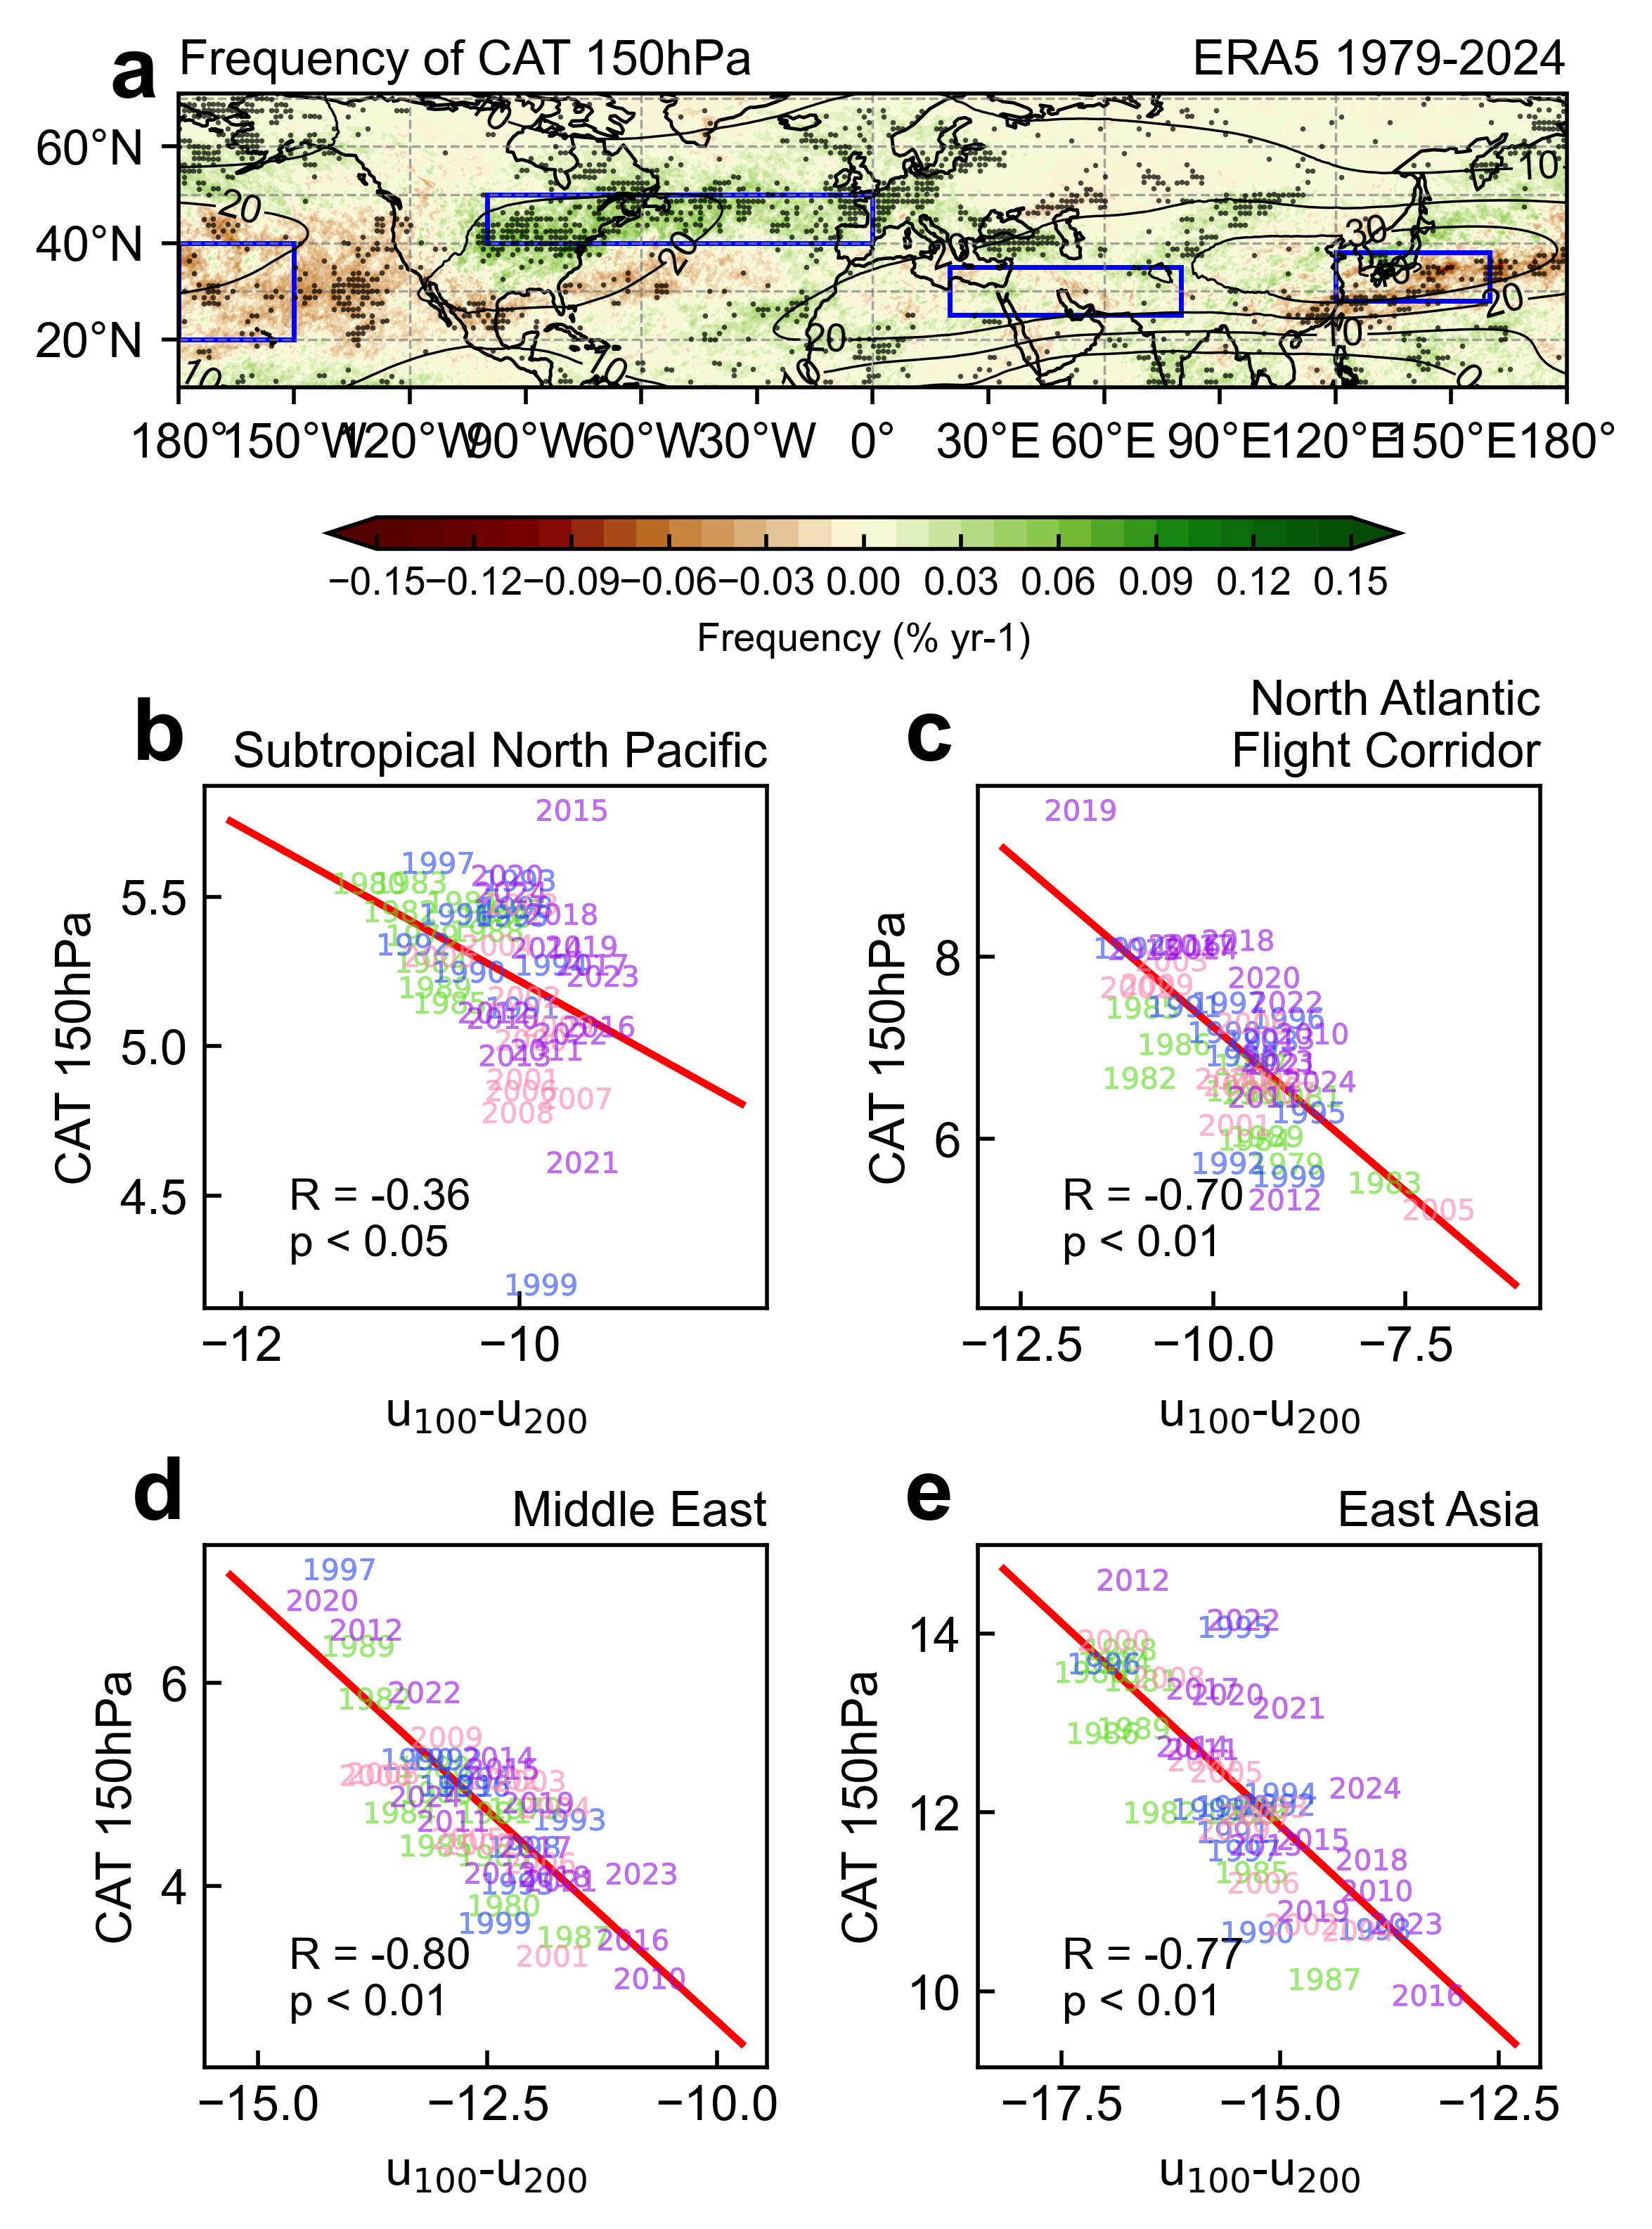

saved 150


In [11]:
levels = [50,100,150,200,250,300]#如果需要循环，就用上这个列表
level = 150

print(f"begin to deal {level}")
freq_trend, freq_p_values = dyl.get_slope_p_3D(combined_freq_new.sel(plev=level*100, method="nearest"))
mask_trend =freq_p_values < 0.05
significant_points= np.where(mask_trend, True, False)
u_clim_mme = np.nanmean(combined_u_new.sel(plev=level*100, method="nearest"), axis=0)

fig = plt.figure(figsize=(5, 9),dpi=500)
# 创建地图投影对象
axes = [[0.125,0.8,0.79,0.195],
        [0.14,0.56,0.32,0.165], [0.58,0.56,0.32,0.165],
        [0.14,0.32,0.32,0.165],[0.58,0.32,0.32,0.165],
        [0.14,0.08,0.32,0.165] ]

ax,contour = plot_trend(fig.add_axes(axes[0],projection=ccrs.PlateCarree()),combined_u.lat, sorted_lon,
           freq_trend,  np.linspace(-0.15, 0.15, 31) ,significant_points,
           f"Frequency of CAT {level}hPa","ERA5 1979-2024",
           'a',wind_speed_clim_mme = u_clim_mme,sequence_size=18,set_aspect_num=1.25,bbox_list=[[180,210,20,40],[260,360,40,50],[20,80,25,35],[120,160,28,38]])

u_100minus200_e30_e80_N25_35 = dhq.mask_am(u_100minus200.sel(lat=slice(25,35),lon=slice(30,80)))
combined_freq_new_e30_e80_N25_35 = dhq.mask_am(combined_freq_new.sel(plev=15000,lat=slice(25,35),lon=slice(30,80)))
u_100minus200_e110_e160_N30_40 = dhq.mask_am(u_100minus200.sel(lat=slice(30,40),lon=slice(110,150)))
combined_freq_new_e110_e160_N30_40 = dhq.mask_am(combined_freq_new.sel(plev=15000,lat=slice(30,40),lon=slice(110,150)))
u_100minus200_w80_w20_N20_40 = dhq.mask_am(u_100minus200.sel(lat=slice(20,40),lon=slice(-80,-20)))
combined_freq_new_w80_w20_N20_40 = dhq.mask_am(combined_freq_new.sel(plev=15000,lat=slice(20,40),lon=slice(-80,-20)))
u_100minus200_w120_w70_N30_40 = dhq.mask_am(u_100minus200.sel(lat=slice(30,40),lon=slice(-120,-70)))
combined_freq_new_w120_w70_N30_40 = dhq.mask_am(combined_freq_new.sel(plev=15000,lat=slice(30,40),lon=slice(-120,-70)))

u_100minus200_w180_e120_N20_40 = dhq.mask_am(u_100minus200.sel(lat=slice(20,40),lon=slice(-180,120)))
combined_freq_new_w180_e120_N20_40 = dhq.mask_am(combined_freq_new.sel(plev=15000,lat=slice(20,40),lon=slice(-180,120)))
u_100minus200_w100_0_N40_50 = dhq.mask_am(u_100minus200.sel(lat=slice(40,50),lon=slice(-100,0)))
combined_freq_new_w100_0_N40_50 = dhq.mask_am(combined_freq_new.sel(plev=15000,lat=slice(40,50),lon=slice(-100,0)))
u_100minus200_0_e60_N20_30 = dhq.mask_am(u_100minus200.sel(lat=slice(20,30),lon=slice(0,60)))
combined_freq_new_0_e60_N20_30 = dhq.mask_am(combined_freq_new.sel(plev=15000,lat=slice(20,30),lon=slice(0,60)))
u_100minus200_e110_e170_N30_40 = dhq.mask_am(u_100minus200.sel(lat=slice(30,40),lon=slice(110,170)))
combined_freq_new_e110_e170_N30_40 = dhq.mask_am(combined_freq_new.sel(plev=15000,lat=slice(30,40),lon=slice(110,170)))

u_100minus200_N20_40 = dhq.mask_am(u_100minus200.sel(lat=slice(20,40)))
combined_freq_new_N20_40 = dhq.mask_am(combined_freq_new.sel(plev=15000,lat=slice(20,40)))

plot_corr_scatter(fig.add_axes(axes[1]),u_100minus200_w180_e120_N20_40,combined_freq_new_w180_e120_N20_40,"Subtropical North Pacific",
                  "b",r"u$_{100}$-u$_{200}$","CAT 150hPa")
plot_corr_scatter(fig.add_axes(axes[2]),u_100minus200_w100_0_N40_50,combined_freq_new_w100_0_N40_50,f"North Atlantic\n Flight Corridor",
                  "c",r"u$_{100}$-u$_{200}$","CAT 150hPa")
plot_corr_scatter(fig.add_axes(axes[3]),u_100minus200_e30_e80_N25_35,combined_freq_new_e30_e80_N25_35,"Middle East",
                  "d",r"u$_{100}$-u$_{200}$","CAT 150hPa")
plot_corr_scatter(fig.add_axes(axes[4]),u_100minus200_e110_e160_N30_40,combined_freq_new_e110_e160_N30_40,"East Asia",
                  "e",r"u$_{100}$-u$_{200}$","CAT 150hPa")
#plot_corr_scatter(fig.add_axes(axes[4]),u_100minus200_N20_40,combined_freq_new_N20_40,"20-40°N",
#                  "e",r"u$_{100}$-u$_{200}$","CAT 150hPa")

cbar_ax = fig.add_axes([0.21, 0.8, 0.61, 0.01])
# 添加横向 colorbar，并设置范围和箭头
cbar = plt.colorbar(contour, cax=cbar_ax, orientation='horizontal', pad=0.15, aspect=50, extend='both')
cbar.set_label(f'Frequency (% yr-1)',fontsize=8)
cbar.set_ticks(np.linspace(-0.15, 0.15, 11))
cbar.ax.tick_params(axis='both', which='major', direction='in',length=3,labelsize=8)


plt.savefig(f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/figures/formal_work/TI1_{level}_era5trend_pattern_u100minus200_4aera.png',format='png',dpi=600)
plt.show()
print(f"saved {level}")